In [76]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import wntr
import numpy as np
import csv
import pickle
import seaborn as sns

from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Get the L_TOWN network:

inp_file = '/Users/maryam/Desktop/Thesis/KIOS-Research-BattLeDIM.git/BattLeDIM/Dataset Generator/L-TOWN_Real.inp'

wn = wntr.network.WaterNetworkModel(inp_file)

In [78]:

#network on the top
nodes =  ['n218', 'n219', 'n220', 'n221', 'n222']
pipes = ['p683', 'p681', 'p682', 'p690', 'p208', 'p687', 'p686', 'p57']


pipe_diameter = {pipe: wn.get_link(pipe).diameter for pipe in pipes}

# For every 5 minutes
DEFAULT_TIMESTEP =  5 * 60


print("NODES:",nodes)
print("PIPES:",pipes)

NODES: ['n218', 'n219', 'n220', 'n221', 'n222']
PIPES: ['p683', 'p681', 'p682', 'p690', 'p208', 'p687', 'p686', 'p57']


In [79]:
def createNetwork(duration, timestep):
    wn = wntr.network.WaterNetworkModel(inp_file) 
    wn.options.hydraulic.demand_model = 'PDD' 
    wn.options.time.duration = duration 
    wn.options.time.hydraulic_timestep = timestep 
    wn.options.time.report_timestep = timestep 
    return wn


def getLeakArea(pipe, percent): 
    d = pipe_diameter[pipe]
    d *= percent
    area = 3.14159 * (d / 2) ** 2 
    return area


def addLeak(wn, pipe, leak_area, leak_start, leak_duration): 
    node_leak = f'{pipe}_leaknode'
    wn = wntr.morph.split_pipe(wn, pipe, f'{pipe}_X', node_leak) 
    node_leak_ref = wn.get_node(node_leak) 
    node_leak_ref.add_leak(wn, discharge_coeff=0.75, area=leak_area,
        start_time=leak_start, end_time=(leak_start+leak_duration))
    return wn, node_leak


def leakResult(wn, pipe, leak_area, leak_start, leak_duration):
    wn, leak_node = addLeak(wn, pipe, leak_area, leak_start, leak_duration) 
    sim = wntr.sim.WNTRSimulator(wn)
    res = sim.run_sim()
    
    # All the pressure values for the sensors
    data = res.node['pressure'].loc[:,nodes]
    
    # Get leakage in l/m
    leak_data = res.node['leak_demand'].loc[:,leak_node].values 
    leak_data = [e * 3600 for e in leak_data]
    
    leak_or_no_leak = ['leak' if e > 0 else 'no_leak' for e in leak_data] 
    
    pipe_as_str = 'pipe_id: ' + str(pipe)
    pipe_or_no_leak = [pipe_as_str if e > 0 else 'no_leak' for e in leak_data] 
    
    data['leak_occurance'] = leak_or_no_leak
    data['pipe_leak_id'] = pipe_or_no_leak 
    
    # Maybe use for some regression method
    data['leak_amount'] = leak_data 
    return data

In [80]:
# Generate Training data:
def generateTrainData():
    # If we want to use TOWN_Real.inp we dont want
    # to load the network every time for each reset
    # so we use pickle
    wn = createNetwork(2 * 24 * 60 * 60, DEFAULT_TIMESTEP) 
    with open('temp_network.pickle', 'wb') as f:
        pickle.dump(wn, f)
    
    leak_start = 12 * 60 * 60 
    leak_duration = 24 * 60 * 60 
    all_results = []
    
    for pipe in pipes:
        print(pipe)
        
        # Use only one leak size for now.. 
        for leak_fraction in [0.15]:
            with open('temp_network.pickle', 'rb') as f:
                wn = pickle.load(f)
            leak_area = getLeakArea(pipe, leak_fraction)
            all_results.append( leakResult(wn, pipe, leak_area, leak_start,leak_duration) )
    
    # Make on big Dataframe
    big_frame = pd.concat(all_results, axis=0) 
    # Store the data in a csv-file
    with open('train_data.csv', 'w') as f:
            w = csv.writer(f)
            w.writerow(big_frame.columns)
            w.writerows(big_frame.values)


In [81]:
generateTrainData()

p683
p681
p682
p690
p208
p687
p686
p57


In [82]:
# Use all sensors
data = pd.read_csv('train_data.csv')

#data.drop_duplicates(inplace=True)
data.head()

,n218,n219,n220,n221,n222,leak_occurance,pipe_leak_id,leak_amount
0,44.530304,45.678510,43.419947,45.945172,46.107824,no_leak,no_leak,0.0
1,44.631108,45.778914,43.519671,46.047539,46.210850,no_leak,no_leak,0.0
2,44.625010,45.772869,43.513512,46.040474,46.203465,no_leak,no_leak,0.0
3,44.669747,45.818150,43.555810,46.083064,46.246197,no_leak,no_leak,0.0
4,44.544889,45.692453,43.435726,45.962348,46.125195,no_leak,no_leak,0.0


In [83]:
data.describe()

,n218,n219,n220,n221,n222,leak_amount
count,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000,4616.000000
mean,44.282705,45.431640,43.169372,45.691037,45.853930,18.884137
std,0.606702,0.603153,0.585090,0.583984,0.584615,22.331945
min,42.723060,43.894934,41.651305,44.190783,44.353720,0.000000
25%,43.921925,45.067728,42.821327,45.341594,45.503456,0.000000
50%,44.291728,45.432481,43.171858,45.691093,45.853370,0.000000
75%,44.650304,45.795388,43.522082,46.044825,46.207986,30.976165
max,45.356758,46.505237,44.205889,46.733752,46.898312,55.844169


In [84]:
data.isna().sum()

n218              0
n219              0
n220              0
n221              0
n222              0
leak_occurance    0
pipe_leak_id      0
leak_amount       0
dtype: int64

In [85]:
data_zero_value = (data == 0).sum(axis=0)
print('Ziro values: ', data_zero_value)

Ziro values:  n218                 0
n219                 0
n220                 0
n221                 0
n222                 0
leak_occurance       0
pipe_leak_id         0
leak_amount       2312
dtype: int64


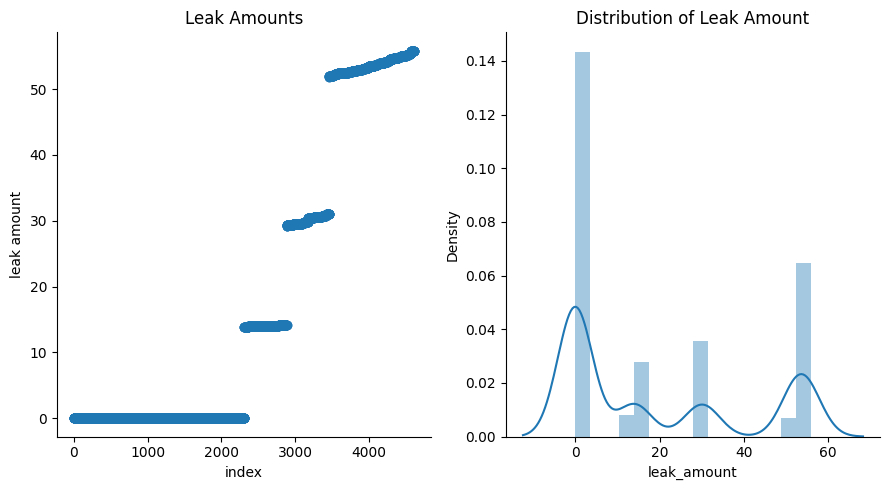

In [86]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

# Scatter plot
axes[0].scatter(range(data.shape[0]), np.sort(data['leak_amount'].values))
axes[0].set_xlabel('index')
axes[0].set_ylabel('leak amount')
axes[0].set_title("Leak Amounts")
sns.despine(ax=axes[0])

# Distribution plot
sns.distplot(data['leak_amount'], ax=axes[1])
axes[1].set_title("Distribution of Leak Amount")
sns.despine(ax=axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the merged plots
plt.show()

In [87]:
# Use all sensors
X = data[nodes]

# 'leak' .. 'no_leak'
y = data['leak_occurance']

print(X)


           n218       n219       n220       n221       n222
0     44.530304  45.678510  43.419947  45.945172  46.107824
1     44.631108  45.778914  43.519671  46.047539  46.210850
2     44.625010  45.772869  43.513512  46.040474  46.203465
3     44.669747  45.818150  43.555810  46.083064  46.246197
4     44.544889  45.692453  43.435726  45.962348  46.125195
...         ...        ...        ...        ...        ...
4611  44.549756  45.697987  43.437735  45.963737  46.126837
4612  44.470217  45.617234  43.365852  45.892921  46.055896
4613  44.544179  45.692417  43.433299  45.959329  46.122270
4614  44.486305  45.634406  43.377915  45.903217  46.065883
4615  44.550564  45.698086  43.444022  45.972114  46.135318

[4616 rows x 5 columns]


In [88]:
print(y.value_counts()) # Shows if the dataset is balanced

leak_occurance
no_leak    2312
leak       2304
Name: count, dtype: int64


In [89]:
y= y.map({'leak': 1, 'no_leak': 0}).astype(int)

<Axes: xlabel='leak_occurance', ylabel='count'>

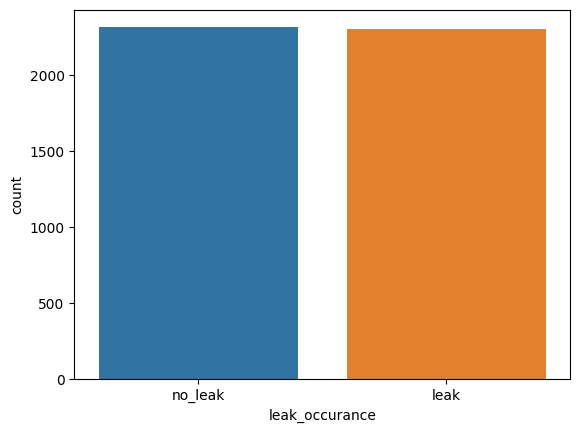

In [90]:

sns.countplot(x = data['leak_occurance'],label="Count")


In [91]:
data['leak_occurance'].value_counts()

leak_occurance
no_leak    2312
leak       2304
Name: count, dtype: int64

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
tuned_params =  {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

cv_method = KFold(n_splits=4, shuffle=True)
model = SVC()
grid = GridSearchCV(estimator=model, param_grid=tuned_params, cv=cv_method, scoring='accuracy')
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       556
           1       0.95      0.81      0.87       598

    accuracy                           0.88      1154
   macro avg       0.89      0.88      0.88      1154
weighted avg       0.89      0.88      0.88      1154



In [93]:
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(1,14))}]
rfc = RandomForestClassifier()
grid_rf = GridSearchCV(estimator=rfc, param_grid=forest_params,  cv=cv_method, scoring='accuracy')
grid_rf.fit(X_train, y_train)
y_pred = grid_rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       556
           1       1.00      0.87      0.93       598

    accuracy                           0.93      1154
   macro avg       0.94      0.94      0.93      1154
weighted avg       0.94      0.93      0.93      1154



In [94]:
dtr = DecisionTreeClassifier()
parameters = {'splitter' : ['best', 'random'],
'criterion' : ['gini', 'entropy'],
'max_features': ['log2', 'sqrt','auto'],
'max_depth': [2, 3, 5, 10, 17],
'min_samples_split': [2, 3, 5, 7, 9],
'min_samples_leaf': [1,5,8,11],
'random_state' : [0,1,2,3,4,5]
}
grid_dt = GridSearchCV(estimator=dtr, param_grid=parameters,  cv=cv_method, scoring='accuracy')
grid_dt.fit(X_train, y_train)
y_pred = grid_dt.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       556
           1       1.00      0.90      0.95       598

    accuracy                           0.95      1154
   macro avg       0.95      0.95      0.95      1154
weighted avg       0.95      0.95      0.95      1154



In [95]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
xgboost = XGBClassifier()
grid_xg = GridSearchCV(estimator=xgboost, param_grid=params,  cv=cv_method, scoring='accuracy')
grid_xg.fit(X_train, y_train)
y_pred = grid_xg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       556
           1       1.00      0.88      0.93       598

    accuracy                           0.94      1154
   macro avg       0.94      0.94      0.94      1154
weighted avg       0.94      0.94      0.94      1154



In [96]:
# DecisionTree
def test_tree(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
    dt = DecisionTreeClassifier() 
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision,recall, f1Score

In [97]:
# SVC
def test_svc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    model = SVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred) # accuracy of the model
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score


In [98]:
# XGBoost
def test_gb(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf1 = XGBClassifier()
    clf1.fit(X_train, y_train)
    y_pred = clf1.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [99]:
# Random forest
def test_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=3)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred) 
    precision = precision_score(y_test, y_pred) # precision of the model
    recall = recall_score(y_test, y_pred) # recall of the model
    f1Score = f1_score(y_test, y_pred) # f1_score of the model
    return score, precision, recall, f1Score

In [100]:

score_DT, precision_DT, recall_DT, f1Score_DT = test_tree(X,y)
print("Leak detection DTC accuracy\t: {:.1f}%".format(score_DT*100))
print("Leak detection DTC precision\t: {:.1f}%".format(precision_DT*100))
print("Leak detection DTC recall\t: {:.1f}%".format(recall_DT*100))
print("Leak detection DTC f1_score\t: {:.1f}%".format(f1Score_DT*100))
print('-------------------------------------------------------------')
score_SVC , precision_SVC, recall_SVC, f1Score_SVC= test_svc(X,y)
print("Leak detection SVC accuracy\t: {:.1f}%".format(score_SVC*100))
print("Leak detection SVC precision\t: {:.1f}%".format(precision_SVC*100))
print("Leak detection SVC recall\t: {:.1f}%".format(recall_SVC*100))
print("Leak detection SVC f1_score\t: {:.1f}%".format(f1Score_SVC*100))
print('-------------------------------------------------------------')
score_XG, precision_XG, recall_XG, f1Score_XG = test_gb(X,y)
print("Leak detection XGBoost accuracy\t: {:.1f}%".format(score_XG*100))
print("Leak detection XGBoost precision\t: {:.1f}%".format(precision_XG*100))
print("Leak detection XGBoost recall\t: {:.1f}%".format(recall_XG*100))
print("Leak detection XGBoost f1_score\t: {:.1f}%".format(f1Score_XG*100))
print('-------------------------------------------------------------')
score_RF, precision_RF, recall_RF, f1Score_RF = test_rf(X,y)
print("Leak detection RandomForest Accuracy\t: {:.1f}%".format(score_RF*100))
print("Leak detection RandomForest precision\t: {:.1f}%".format(precision_RF*100))
print("Leak detection RandomForest recall\t: {:.1f}%".format(recall_RF*100))
print("Leak detection RandomForest f1_score\t: {:.1f}%".format(f1Score_RF*100))

Leak detection DTC accuracy	: 95.8%
Leak detection DTC precision	: 100.0%
Leak detection DTC recall	: 91.6%
Leak detection DTC f1_score	: 95.6%
-------------------------------------------------------------
Leak detection SVC accuracy	: 75.5%
Leak detection SVC precision	: 93.2%
Leak detection SVC recall	: 55.7%
Leak detection SVC f1_score	: 69.7%
-------------------------------------------------------------
Leak detection XGBoost accuracy	: 95.9%
Leak detection XGBoost precision	: 100.0%
Leak detection XGBoost recall	: 91.9%
Leak detection XGBoost f1_score	: 95.8%
-------------------------------------------------------------
Leak detection RandomForest Accuracy	: 97.1%
Leak detection RandomForest precision	: 100.0%
Leak detection RandomForest recall	: 94.2%
Leak detection RandomForest f1_score	: 97.0%
